In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector, DensityMatrix
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.transpiler import Target


from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError
from qiskit.result import Result
from qiskit.quantum_info import Statevector

In [2]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
# h_backend = provider.get_backend("ibmq_lima")

In [169]:
qubit_frequency= 5e9
anharmonicity= -0.25e9
lambda_1= 1e9
lambda_2= 0.8e9
gamma_1 = 0.01e9

qubit_frequency_02 = 2 * qubit_frequency + anharmonicity
ket0 = np.array([[1, 0, 0]]).T
ket1 = np.array([[0, 1, 0]]).T
ket2 = np.array([[0, 0, 1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

p1 = ket1 @ ket1.T.conj()
p2 = ket2 @ ket2.T.conj()

s_p = ket0 @ ket1.T

drift = 2 * np.pi * (qubit_frequency * p1 + qubit_frequency_02 * p2)
control = [
    2
    * np.pi
    * (lambda_1 * (sigma_p1 + sigma_m1) + lambda_2 * (sigma_p2 + sigma_m2))
]
r_frame = 2 * np.pi * qubit_frequency * (p1 + 2 * p2)

# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    static_dissipators=[np.sqrt(gamma_1) * s_p],
    rotating_frame=r_frame,
    rwa_cutoff_freq=1.9 * qubit_frequency,
    rwa_carrier_freqs=[qubit_frequency],
    evaluation_mode = "dense_vectorized"
)

In [170]:
# hamiltonian_solver.model.evaluate(0)

In [177]:
y0 = np.eye(9)#DensityMatrix(ket0 @ ket0.T) #Statevector([1.0, 0.0, 0.0])
dt = 0.1*1e-9
sigma = 40
amp =  0.05833786
duration = 160
T = duration * dt

In [178]:

# Gamma_2 = 0.1e9

# y0 = DensityMatrix.from_label('0')


In [179]:
converter = InstructionToSignals(dt, carriers={"d0": qubit_frequency})
def make_signal(duration, amp, sigma, w, dt=dt):

    with pulse.build(name="spec") as spec:
        shift = w - qubit_frequency
        pulse.shift_frequency(shift, pulse.DriveChannel(0))
        pulse.play(
            pulse.Gaussian(duration=duration, amp=amp, sigma=sigma),
            pulse.DriveChannel(0),
        )
        pulse.shift_frequency(-shift, pulse.DriveChannel(0))

    signals = converter.get_signals(spec)
    return signals, spec.draw()

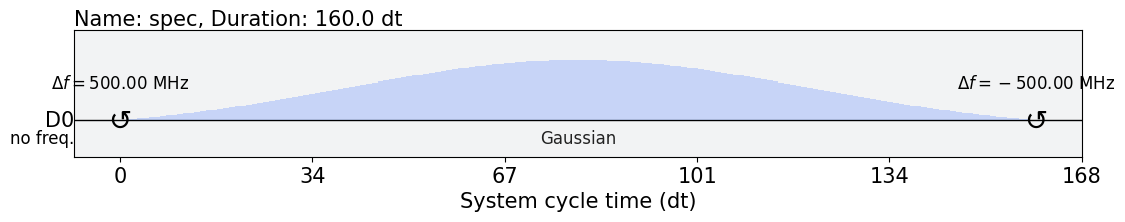

In [180]:
make_signal(duration, amp, sigma, qubit_frequency*1.1, dt=dt)[1]

In [181]:
result = hamiltonian_solver.solve(
    t_span=[0.0, T*2],
    y0=y0,
#     t_eval=[T],
    signals=make_signal(duration, amp, sigma, qubit_frequency, dt=dt)[0],
    method="RK23",
).y

In [195]:
result.shape

(148, 9, 9)

In [191]:
rho_g = ket0 @ ket0.T
gs_vec = rho_g.T.reshape(9, 1)
gs_vec

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [214]:
result_vec = [DensityMatrix((res @ gs_vec).reshape(3,3)) for res in result]

In [205]:
(result[-1] @ gs_vec)

array([[ 2.04165570e-01-4.68287822e-18j],
       [-2.89451500e-02-2.56898857e-02j],
       [ 1.40484883e-04-1.11167061e-04j],
       [-2.89451500e-02+2.56898857e-02j],
       [ 7.95812647e-01+4.49409759e-18j],
       [-7.56649603e-04+3.51776950e-03j],
       [ 1.40484883e-04+1.11167061e-04j],
       [-7.56649603e-04-3.51776950e-03j],
       [ 2.17831512e-05+1.34393491e-19j]])

In [232]:
DensityMatrix((result[1] @ gs_vec).reshape(3,3)).sample_counts(1000)

{'0': 1000}

In [235]:
DensityMatrix((result[10] @ gs_vec).reshape(3,3)).probabilities()

array([9.99990123e-01, 9.87659661e-06, 1.50534807e-11])

In [241]:
np.log10(83.38e-6)


-4.078938109209721

In [239]:
b = a / np.trace(a)

In [240]:
np.trace(b)

1.0

In [215]:
probs = np.array([den.probabilities() for den in result_vec])

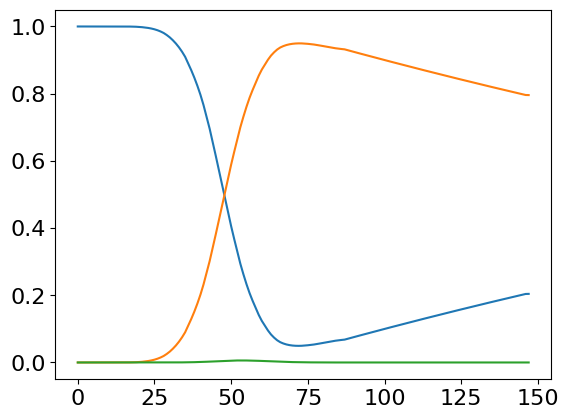

In [216]:
plt.plot(probs)